# Predict Concentrations of Metabolites

The objective is to see whether continuous vector embedding can help in the prediction of concentrations of metabolites.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import pandas as pd

from rdkit import Chem
from keras.models import Sequential, Model, load_model

Using TensorFlow backend.


In [3]:
import sys
sys.path.append('/Users/joewandy/git/keras-molecules')

from molecules.model import MoleculeVAE
from molecules.utils import load_dataset
    
from embedding import to_one_hot_array, get_input_arr, autoencode, encode
from embedding import visualize_latent_rep, get_classifyre, get_scatter_colours

In [4]:
plt.style.use('seaborn-notebook')

## Load Standards Data

In [5]:
df = pd.read_csv('data_all_standards.csv')

In [6]:
df.head()

,MolNames,6.64385619,4.321928095,3.321928095,1,0,-3.321928095,Polarity,Smiles,molP,...,Sol,Neg,Pos,Ref,logP,logD,TPSA,H-donors,H-acceptors,intercept
0,(R)-2-Hydroxyglutarate,28.040059,26.137714,24.932028,21.940297,20.596751,19.343515,-,C(CC(=O)[O-])C(C(=O)[O-])O,12.10,...,1.440,-0.460016,0.090000,51.30,-0.82,-7.86,100.49,1,5,-21.690885
1,(R)-3-Hydroxybutanoate,25.125038,23.580667,22.565952,19.735421,18.903932,16.081962,-,CC(CC(=O)[O-])O,9.54,...,1.910,-0.460026,0.060000,34.30,-0.39,-3.88,60.36,1,3,-19.080706
2,(R)-Lactate,22.606994,21.187252,20.203095,18.626611,18.606832,18.899018,-,C[C@@H](O)C(O)=O,7.65,...,1.840,-0.430003,0.090000,29.68,-0.47,-3.99,57.53,2,3,-38.689586
3,(S)-Malate,23.532449,24.837572,24.273645,21.909507,22.111403,19.982056,-,O[C@@H](CC(O)=O)C(O)=O,10.08,...,1.380,-0.420136,0.100000,46.55,-1.11,-8.01,94.83,3,5,-32.948489
4,1-Aminocyclopropane-1-carboxylate,22.869941,20.824939,20.287416,17.982119,18.015671,17.481074,+,C1CC1(C(=O)[O-])N,9.54,...,-0.558,0.030000,0.761236,45.38,-2.72,-2.86,66.15,1,3,-32.880587


In [7]:
df.shape

(172, 31)

In [8]:
def plot_graph(df, conc_label, feature_label):

    x = np.array(df[feature_label], dtype=float)
    y = np.array(df[conc_label], dtype=float) 
    plt.scatter(x, y, s=10)
    
    slope, intercept, r_value, p_value, std_err=stats.linregress(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print ("r_value = " + str(r_value))

    plt.title(feature_label + ' v intensity')
    plt.xlabel(feature_label)
    plt.ylabel('Intensity (@20uM)')
    plt.text((np.min(x)+1), (np.max(y)-1), "y=%.6fx+(%.6f)"%(z[0], z[1]))
    
    return y

r_value = -0.52281393289


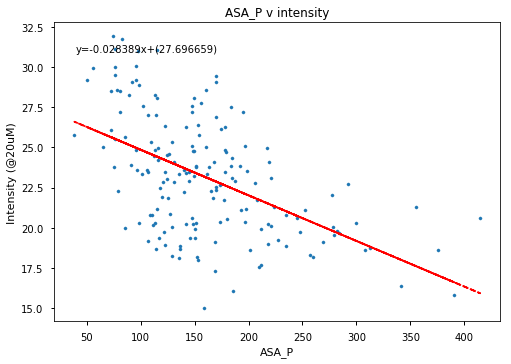

In [9]:
y = plot_graph(df, '4.321928095', 'ASA_P')

## Try ordinary least squares regression on all the chemical properties

In [10]:
X = df[['molP', 'TPSA9', 'VDWSA', 
        'ASA', 'ASA+', 'ASA-', 
        'ASA_H', 'ASA_P', 'MW', 
        'NC', 'PC', 'HLB', 
        'Sol', 'Neg', 'Pos', 
        'Ref', 'logP', 'logD', 
        'TPSA', 'H-donors', 'H-acceptors']].values.astype(float)

In [11]:
print X.shape
print y.shape

(172, 21)
(172,)


Performs 10-folds cross-validation on the regression model. 

`cross_val_predict` returns an array of the same size as `y` where each entry is a prediction obtained by cross validation

In [12]:
k = 10
lr = LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=k)

r_value = 0.583389269416


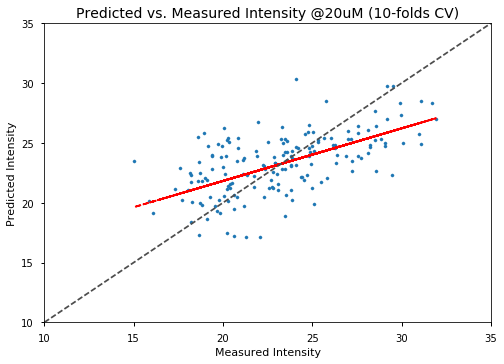

In [17]:
fig, ax = plt.subplots()
ax.scatter(y, predicted, s=10)

slope, intercept, r_value, p_value, std_err=stats.linregress(y, predicted)
z = np.polyfit(y, predicted, 1)
p = np.poly1d(z)
ax.plot(y, p(y), "r--")
print ("r_value = " + str(r_value))

ax.set_xlim((10, 35))
ax.set_ylim((10, 35))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

ax.set_xlabel('Measured Intensity')
ax.set_ylabel('Predicted Intensity')
plt.title('Predicted vs. Measured Intensity @20uM (10-folds CV)', size=14)

## Now try the embedding stuff

Load model

In [18]:
base_dir = '/Users/joewandy/git/keras-molecules/'
data_file = base_dir + 'data/smiles_500k_processed.h5'
model_file = base_dir + 'data/smiles_500k_model_292.h5'
latent_dim = 292

In [19]:
_, charset = load_dataset(data_file, split=False)
print charset

[' ' '(' '.' '0' '2' '4' '6' '8' '@' 'B' 'F' 'H' 'L' 'N' 'P' 'T' 'V' 'X'
 'Z' '\\' 'l' 'n' 'p' 'r' 't' '#' '%' ')' '+' '-' '/' '1' '3' '5' '7' '9'
 '=' 'A' 'C' 'I' 'K' 'M' 'O' 'S' '[' ']' 'a' 'c' 'e' 'g' 'i' 'o' 's']


In [20]:
model = MoleculeVAE()
model.load(charset, model_file, latent_rep_size=latent_dim)

Get the SMILES strings of our standards molecules, and convert them to canonical SMILES strings using rdkit.

In [21]:
smiles_list = df['Smiles'].values.tolist()
smiles_list = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in smiles_list]

Pre-process the SMILES strings.

In [22]:
input_array = get_input_arr(smiles_list, charset)

Try to auto-encode a few SMILES for sanity check.

In [23]:
autoencode(model, charset, input_array, N=10)

i> O=C([O-])CCC(O)C(=O)[O-]
o> CCCC[C@]1(CC(C)C(=O)[O-]

i> CC(O)CC(=O)[O-]
o> CC(=NNC(=O)[O-]

i> CC(O)C(=O)O
o> CC(C)C(=O)O

i> O=C(O)CC(O)C(=O)O
o> CC(=O)CC(O)C(=O)O

i> NC1(C(=O)[O-])CC1
o> CC.OC(=O)[Oe]CCCl

i> CC(O)CN
o> CC(C)CO

i> NC1CCOC1=O
o> CC1CCCC1=O

i> O=C(O)CCC(=O)C(=O)O
o> CC(=C)CCC(=O)C(=O)O

i> NC(C(=O)O)c1ccccc1
o> CCOC(=O)O)c1ccccc1

i> O=C(O)C(CO)OP(=O)(O)O
o> CCC(C)CC(O)NP(=O)(O)O

i> O=C(O)Cc1ccc(O)c(O)c1
o> CC(=N)Cc1ccc(O)c(O)c1

i> O=C(O)C(=O)Cc1ccc(O)cc1
o> CC(=C)C(=O)Cc1ccc(O)cc1



Extract the latent vectors

In [24]:
X_latent = encode(model, input_array)
print X_latent.shape

(172, 292)


Visualise the latent vectors

pca_comp=50
Explained variations -- first two PCs: 0.41
Explained variations -- all components: 0.99
[ 0.26519063  0.14348904  0.09483237  0.07011444  0.06035946  0.05022574
  0.04147628  0.0399762   0.03314864  0.02621086  0.02141241  0.02025883
  0.01819522  0.01526985  0.01239972  0.0119284   0.01012938  0.007273
  0.00663805  0.00592355  0.00389944  0.003777    0.0035484   0.00275401
  0.00232008  0.00214943  0.00199535  0.00158093  0.00133533  0.00103618
  0.00091498  0.00072083  0.00069037  0.00063802  0.00055369  0.00053553
  0.00048147  0.0004078   0.00037065  0.00035715  0.00034231  0.00033353
  0.00031604  0.00031101  0.00029847  0.00029527  0.00029     0.00028511
  0.00027986  0.00027402]


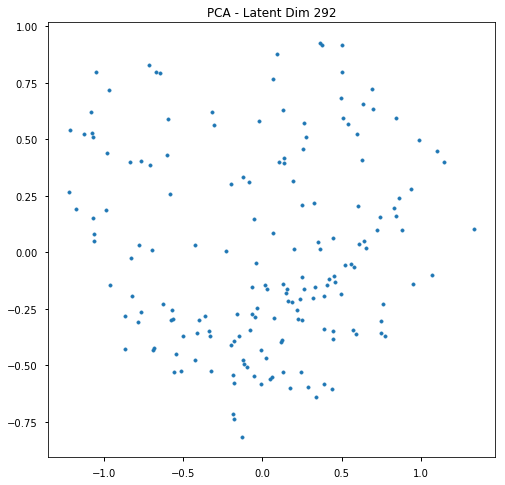

In [25]:
visualize_latent_rep(input_array, model, latent_dim)

Concatenate the latent + chemical features for regression

In [26]:
X_new = np.concatenate((X, X_latent), axis=1)

print X.shape
print X_latent.shape
print X_new.shape

(172, 21)
(172, 292)
(172, 313)


Make new predictions using X_new

In [27]:
predicted_new = cross_val_predict(lr, X_new, y, cv=k)

In [30]:
def make_plot(predicted, predicted_new, y):

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 7))

    ax1.scatter(y, predicted, s=10)
    slope, intercept, r_value, p_value, std_err=stats.linregress(y, predicted)
    z = np.polyfit(y, predicted, 1)
    p = np.poly1d(z)
    ax1.plot(y, p(y), "r--")

    ax1.set_title('Chemical Features')
    ax1.set_ylabel('Predicted Intensity')
    ax1.set_xlabel('Measured Intensity')

    ax2.scatter(y, predicted_new, s=10)
    slope, intercept, r_value, p_value, std_err=stats.linregress(y, predicted_new)
    z = np.polyfit(y, predicted_new, 1)
    p = np.poly1d(z)
    ax2.plot(y, p(y), "r--")
    ax2.set_title('Chemical + Embedding Features')
    ax2.set_xlabel('Measured Intensity')

    ax1.set_xlim((10, 40))
    ax2.set_xlim((10, 40))
    ax1.set_ylim((10, 40))

    ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")

    plt.suptitle('Predicted vs. Measured Intensity @20uM (10-folds CV)', size=14)

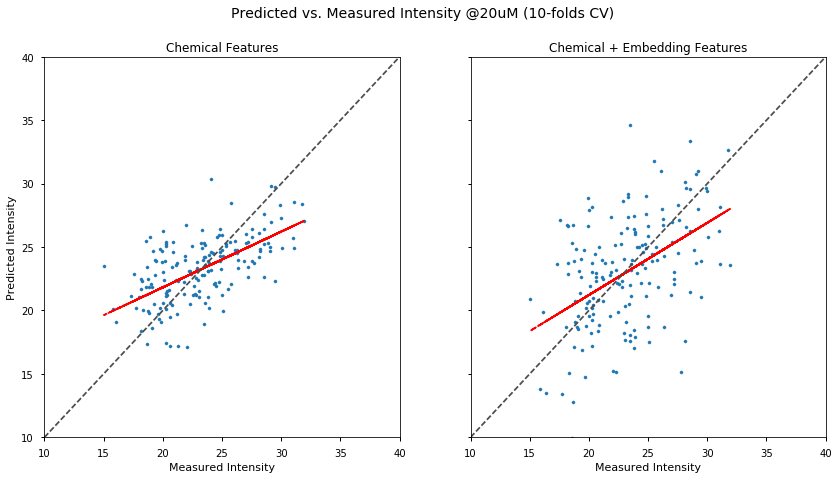

In [31]:
make_plot(predicted, predicted_new, y)

## Try other regressions

Try ridge regression

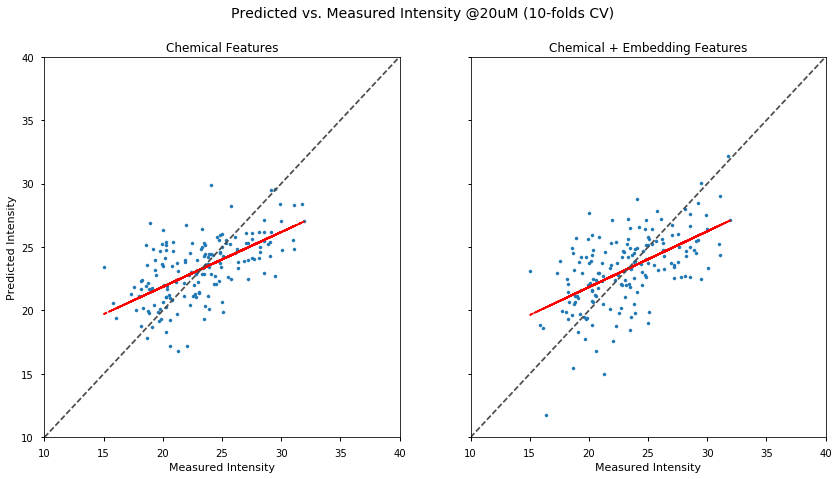

In [32]:
reg = linear_model.Ridge()
predicted = cross_val_predict(reg, X, y, cv=k)
predicted_new = cross_val_predict(reg, X_new, y, cv=k)
make_plot(predicted, predicted_new, y)

Try gaussian process regression with this kernel: 

http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py

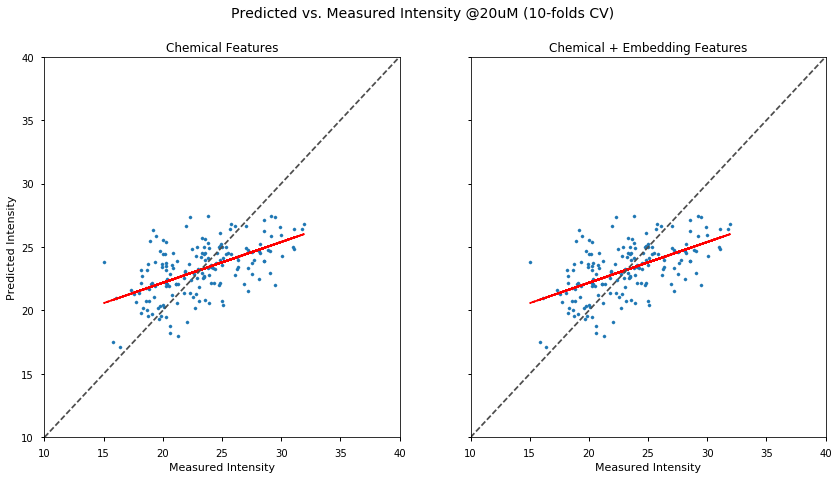

In [33]:
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
predicted = cross_val_predict(gp, X, y, cv=k)
predicted_new = cross_val_predict(gp, X_new, y, cv=k)
make_plot(predicted, predicted_new, y)